In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Check the area of the original footfall data

In [ ]:
base_path = "/content/drive/MyDrive/GEOG0105"

locations = pd.read_csv(f"{base_path}/bespoke_london_ff_locations.csv")

In [ ]:
locations

,location,address,city,region,lat,lon,position,type
0,8,"Holborn Bars, 3 Holborn, London, EC1N 2LL, Gre...",London,Greater London,51.51806,-0.11111,NaN,External
1,9,"4 Gray's Inn Road, London, WC1X 8HG, Greater L...",London,Greater London,51.51825,-0.11122,NaN,External
2,10,"19-20 Great Sutton Street, London, EC1V 0DR, G...",London,Greater London,51.52329,-0.10053,NaN,Internal
3,11,"76 New Oxford Street, London, WC1A 1EU, Greate...",London,Greater London,51.51684,-0.12749,NaN,External
4,12,"18 Hammersmith Broadway, London, W6 7AB, Great...",London,Greater London,51.49340,-0.22403,NaN,External
...,...,...,...,...,...,...,...,...
479,1210,"173 Edgware Road, London, W2 2HR, Greater London",London,Greater London,51.51784,-0.16735,Specsavers,External
480,1216,"90-100 Edgware Road, London, W2 2EA, Greater L...",London,Greater London,51.51555,-0.16349,Tesco Metro,External
481,1213,"9 Spring Street, London, W2 3RA, Greater London",London,Greater London,51.51458,-0.17568,Headcase,External
482,1197,"163-165 Praed Street, London, W2 1RH, Greater ...",London,Greater London,51.51581,-0.17499,Angus Steak House,Internal


In [ ]:
borough_path = "/content/drive/MyDrive/GEOG0105/Research_Area/London_Boroughs_Shapefile.shp"
borough_gdf = gpd.read_file(borough_path).to_crs("EPSG:4326")

lsoa_path = "/content/drive/MyDrive/GEOG0105/Research_Area/London_LSOA_areas.shp"
lsoa_gdf = gpd.read_file(lsoa_path).to_crs("EPSG:4326")
lsoa_gdf

,LSOA_code,LSOA_name,geometry
0,E01000815,Bromley 025E,"POLYGON ((0.07637 51.39487, 0.07695 51.39513, ..."
1,E01001280,Ealing 011D,"POLYGON ((-0.2961 51.52223, -0.29589 51.52325,..."
2,E01001353,Ealing 033A,"POLYGON ((-0.27714 51.50244, -0.27693 51.50259..."
3,E01003830,Richmond upon Thames 020C,"POLYGON ((-0.36861 51.43196, -0.36752 51.43215..."
4,E01003885,Richmond upon Thames 016D,"POLYGON ((-0.34294 51.43844, -0.34198 51.43846..."
...,...,...,...
4963,E01004630,Wandsworth 022B,"POLYGON ((-0.21972 51.44986, -0.21821 51.44909..."
4964,E01004631,Wandsworth 022C,"POLYGON ((-0.22129 51.44908, -0.2214 51.44873,..."
4965,E01004633,Wandsworth 022D,"POLYGON ((-0.21486 51.44763, -0.21389 51.44706..."
4966,E01033099,Wandsworth 004E,"POLYGON ((-0.17783 51.47234, -0.17781 51.47238..."


/tmp/ipython-input-113-1767262749.py:47: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


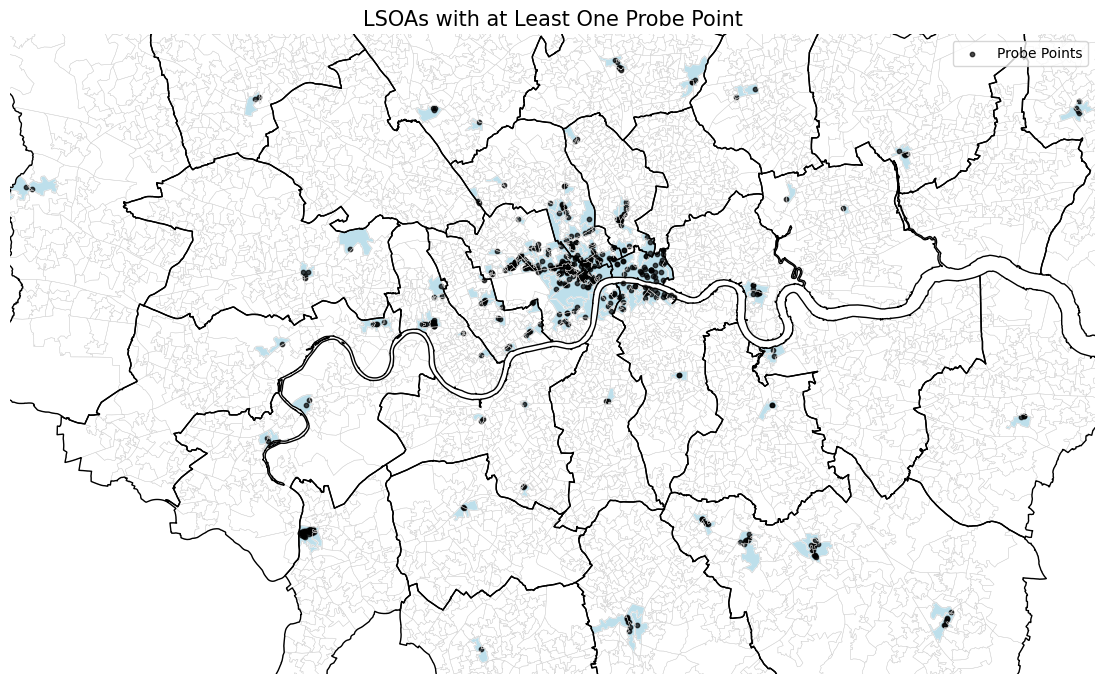

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Split 'LSOA_name' into 'borough_name' and 'lsoa_local_code'
lsoa_gdf[['borough_name', 'lsoa_local_code']] = lsoa_gdf['LSOA_name'].str.rsplit(' ', n=1, expand=True)

# Create GeoDataFrame for probe points
locations["geometry"] = locations.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
probe_gdf = gpd.GeoDataFrame(locations, geometry="geometry", crs="EPSG:4326")

# Spatial join: assign each probe to an LSOA
probes_with_lsoa = gpd.sjoin(
    probe_gdf,
    lsoa_gdf[['LSOA_code', 'geometry']],
    predicate="within",
    how="left"
)

# Get LSOAs that contain at least one probe
lsoas_with_probes = probes_with_lsoa['LSOA_code'].dropna().unique()
highlight_lsoas = lsoa_gdf[lsoa_gdf['LSOA_code'].isin(lsoas_with_probes)]

# Plot
fig, ax = plt.subplots(figsize=(14, 14))

# LSOA boundaries (light gray)
lsoa_gdf.boundary.plot(ax=ax, linewidth=0.3, edgecolor='lightgray')

# Borough boundaries
borough_gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Highlight LSOAs with probes
highlight_lsoas.plot(ax=ax, color='#ADD8E6', edgecolor='white', alpha=0.8, label="LSOA with Probe")

# Plot all probe points
probe_gdf.plot(ax=ax, markersize=10, color='black', alpha=0.7, label="Probe Points")

# Set zoom based on probe extent
minx, miny, maxx, maxy = probe_gdf.total_bounds
padding = 0.01
ax.set_xlim(minx - padding, maxx + padding)
ax.set_ylim(miny - padding, maxy + padding)

plt.title("LSOAs with at Least One Probe Point", fontsize=15)
plt.axis("off")
plt.legend()
plt.show()



/tmp/ipython-input-32-3556124782.py:46: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


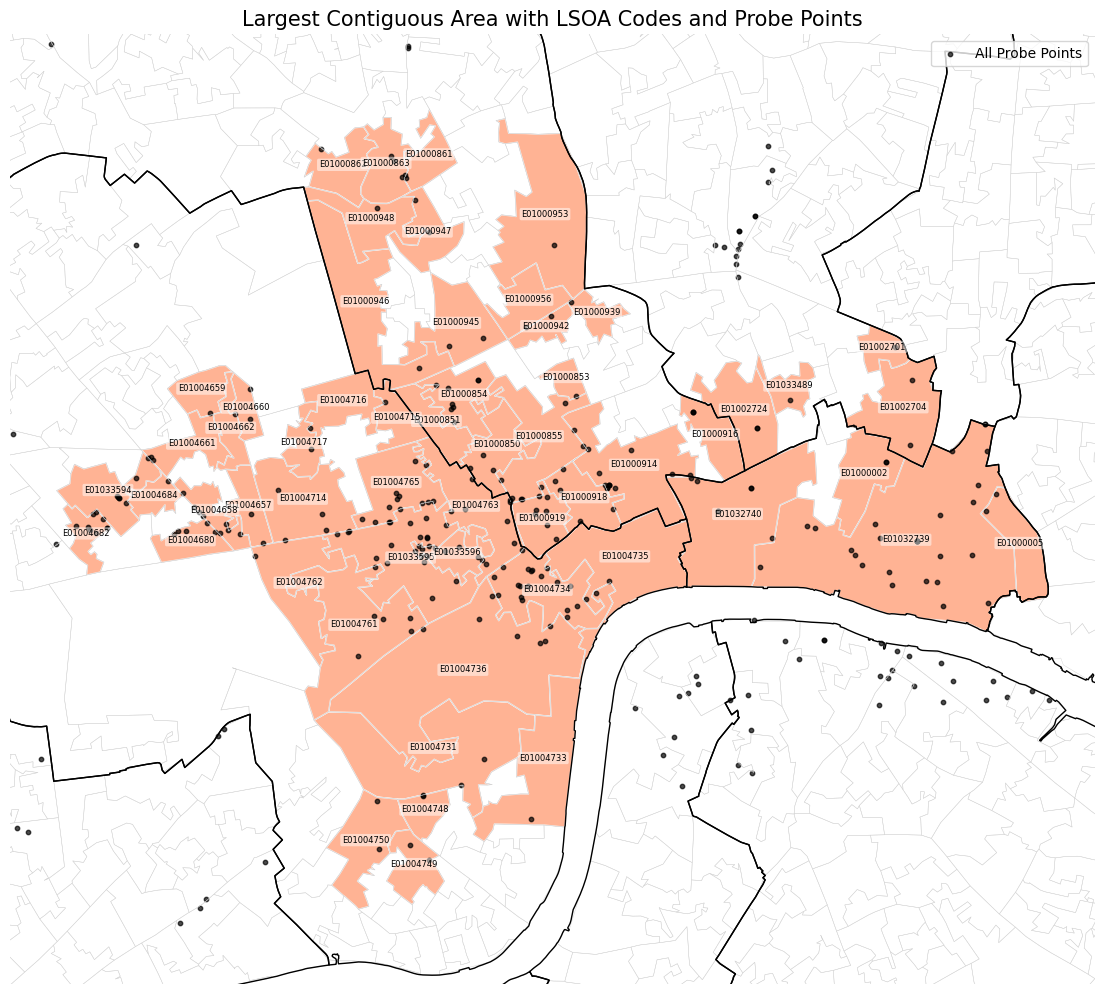

In [ ]:
from shapely.ops import unary_union
from shapely.geometry import Polygon, MultiPolygon

# 1. Combine all highlighted LSOA polygons into a union
union_geom = unary_union(highlight_lsoas.geometry)

# 2. Extract the largest connected area
if isinstance(union_geom, MultiPolygon):
    largest_area_geom = max(union_geom.geoms, key=lambda g: g.area)
else:
    largest_area_geom = union_geom

# 3. Find which LSOAs intersect the largest area
largest_region_lsoas = highlight_lsoas[highlight_lsoas.intersects(largest_area_geom)]

# 4. Plot
fig, ax = plt.subplots(figsize=(14, 14))

# Base layers
lsoa_gdf.boundary.plot(ax=ax, linewidth=0.3, edgecolor='lightgray')
borough_gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Highlight the largest connected cluster
largest_region_lsoas.plot(ax=ax, color='#FFA07A', edgecolor='white', alpha=0.8, label="Largest Probe Cluster")

# Plot all probe points
probe_gdf.plot(ax=ax, markersize=10, color='black', alpha=0.7, label="All Probe Points")

# 5. Annotate each LSOA_code in the largest block
for idx, row in largest_region_lsoas.iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y, row["LSOA_code"],
        fontsize=6, color='black', ha='center',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2')
    )

# Zoom into the area
minx, miny, maxx, maxy = largest_region_lsoas.total_bounds
padding = 0.005
ax.set_xlim(minx - padding, maxx + padding)
ax.set_ylim(miny - padding, maxy + padding)

plt.title("Largest Contiguous Area with LSOA Codes and Probe Points", fontsize=15)
plt.axis("off")
plt.legend()
plt.show()


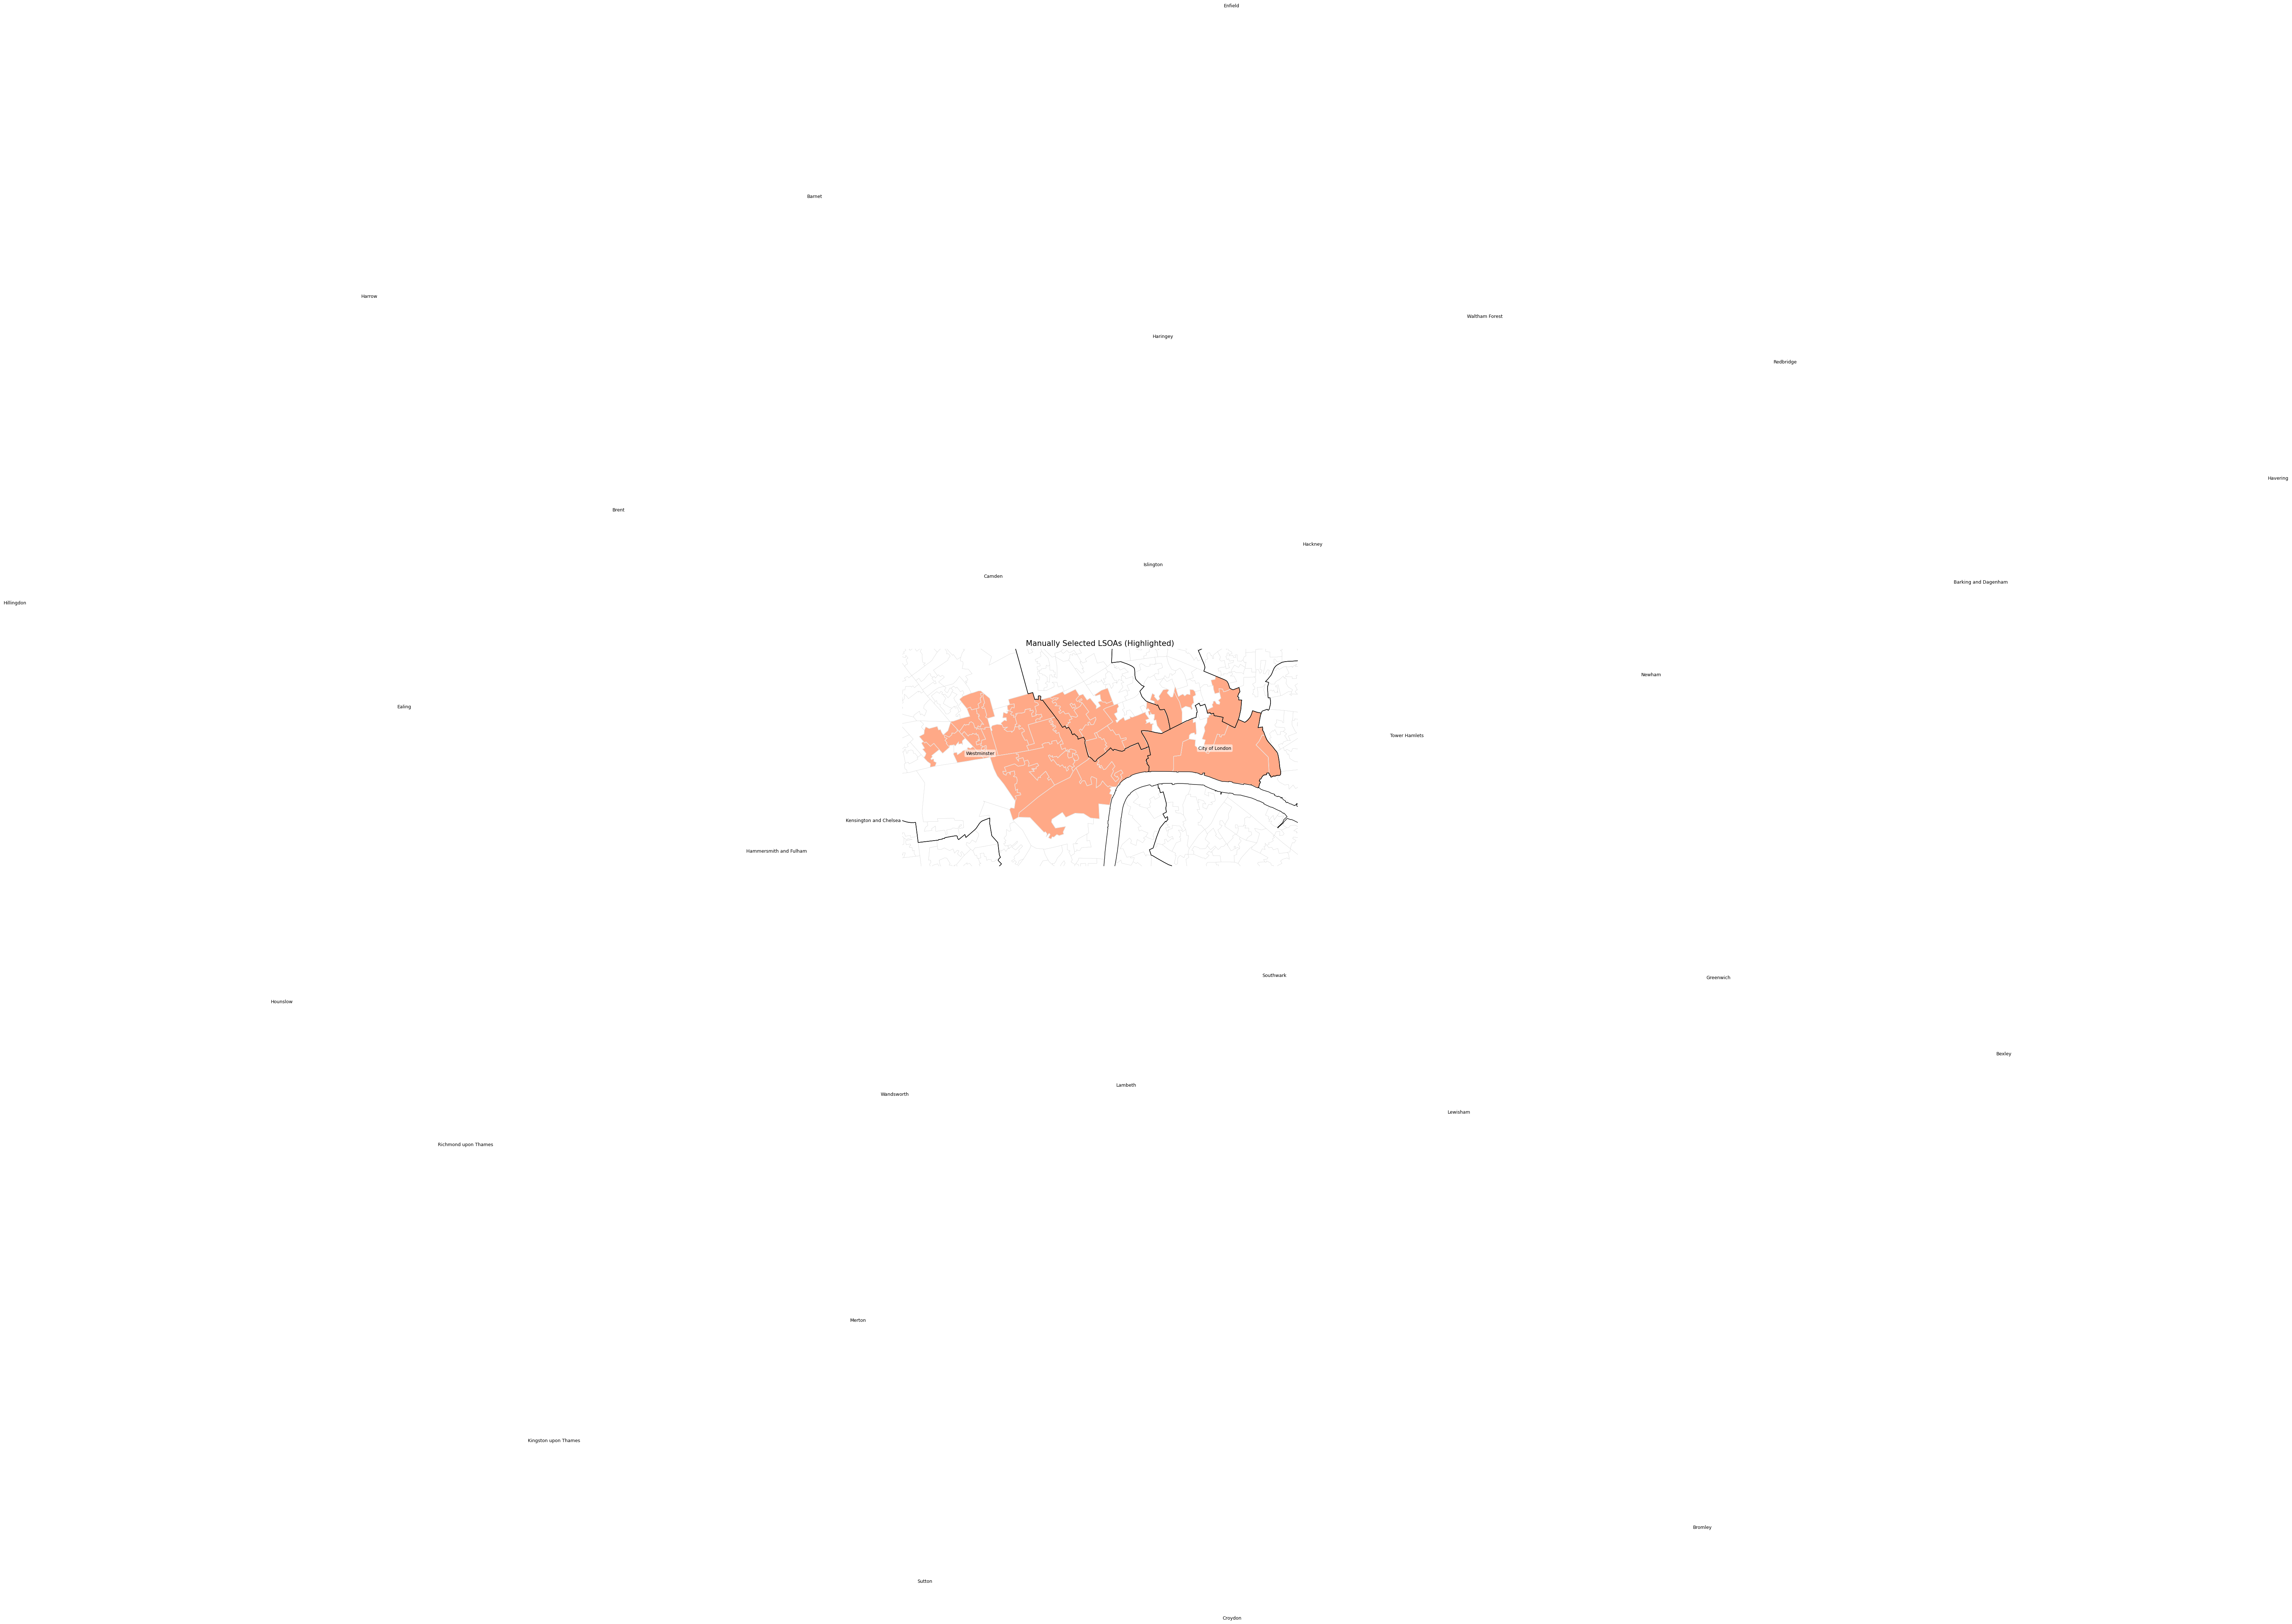

In [ ]:
# Manually selected LSOA code list
selected_lsoa_codes = [
    "E01004682", "E01033594", "E01004684", "E01004661", "E01004680", "E01004658",
    "E01004659", "E01004657", "E01004662", "E01004660", "E01004717", "E01004714",
    "E01004762", "E01004716", "E01004761", "E01004763", "E01004715", "E01004765",
    "E01033595", "E01033596", "E01004736", "E01000851", "E01000854", "E01000850",
    "E01000855", "E01000919", "E01004734", "E01000853", "E01000918", "E01004713",
    "E01000914", "E01004735", "E01000916", "E01032740", "E01002724", "E01033489",
    "E01000002", "E01002701", "E01002704", "E01032739", "E01000005", "E01004663"
]

# Extract selected LSOA geometries
highlighted_lsoa = lsoa_gdf[lsoa_gdf["LSOA_code"].isin(selected_lsoa_codes)]

# Plot
fig, ax = plt.subplots(figsize=(14, 14))

# LSOA boundaries (light gray background)
lsoa_gdf.boundary.plot(ax=ax, linewidth=0.3, edgecolor='lightgray')

# Borough boundaries (black)
borough_gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Highlight manually selected LSOAs
highlighted_lsoa.plot(ax=ax, color='#FFA07A', edgecolor='white', alpha=0.9)

# Label borough names at centroid
for idx, row in borough_gdf.iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y, row["ctyua16nm"],
        fontsize=9, ha='center',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.3')
    )

# Zoom to selected LSOAs
minx, miny, maxx, maxy = highlighted_lsoa.total_bounds
padding = 0.005
ax.set_xlim(minx - padding, maxx + padding)
ax.set_ylim(miny - padding, maxy + padding)

plt.title("Manually Selected LSOAs (Highlighted)", fontsize=15)
plt.axis("off")
plt.show()


In [ ]:
from shapely.ops import unary_union

# Merge selected LSOA polygons into a single shape
research_area_outline = unary_union(highlighted_lsoa.geometry)


# Extract the shapefile of the research area in Camden, Westminister, City of London

To maintain data consistency, some regions have retained the original data format. Since in practice, data can be consolidated upwards through region merging, but it is difficult to accurately split into smaller new code units, we have chosen to retain the original unsplit old codes (e.g., E01035716) for the new version of split regions, such as E01033595 and E01033596, in order to ensure the consistency of the region boundaries and the comparability of the data.

In [ ]:
Camden_path = "/content/drive/MyDrive/GEOG0105/Research_Area/Camden.shp"
Camden_gdf = gpd.read_file(Camden_path).to_crs("EPSG:4326")

City_of_London_path = "/content/drive/MyDrive/GEOG0105/Research_Area/City of London.shp"
City_of_London_gdf = gpd.read_file(City_of_London_path).to_crs("EPSG:4326")

Westminster_path = "/content/drive/MyDrive/GEOG0105/Research_Area/Westminster.shp"
Westminster_gdf = gpd.read_file(Westminster_path).to_crs("EPSG:4326")

Islington_path = "/content/drive/MyDrive/GEOG0105/Research_Area/Islington.shp"
Islington_gdf = gpd.read_file(Islington_path).to_crs("EPSG:4326")

combined_gdf = gpd.GeoDataFrame(pd.concat(
    [Camden_gdf, City_of_London_gdf, Westminster_gdf, Islington_gdf],
    ignore_index=True
), crs="EPSG:4326")

In [ ]:
highlighted_lsoa = combined_gdf[combined_gdf["lsoa21cd"].isin(selected_lsoa_codes)]
research_area_outline = unary_union(highlighted_lsoa.geometry)

# Plot
fig, ax = plt.subplots(figsize=(14, 14))

# Base LSOA fill
combined_gdf.plot(ax=ax, color="#D3D3D3", edgecolor="white", linewidth=0.5)

# LSOA label
for idx, row in combined_gdf.iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y, row["lsoa21cd"],
        fontsize=6, ha='center', color='black',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, boxstyle='round,pad=0.2')
    )

# Highlight research area outline
gpd.GeoSeries([research_area_outline], crs="EPSG:4326").boundary.plot(
    ax=ax, edgecolor="red", linewidth=2, label="Research Area Outline"
)

plt.title("Combined Borough LSOAs with Research Area Boundary", fontsize=15)
plt.axis("off")
plt.legend()
plt.tight_layout()
plt.show()

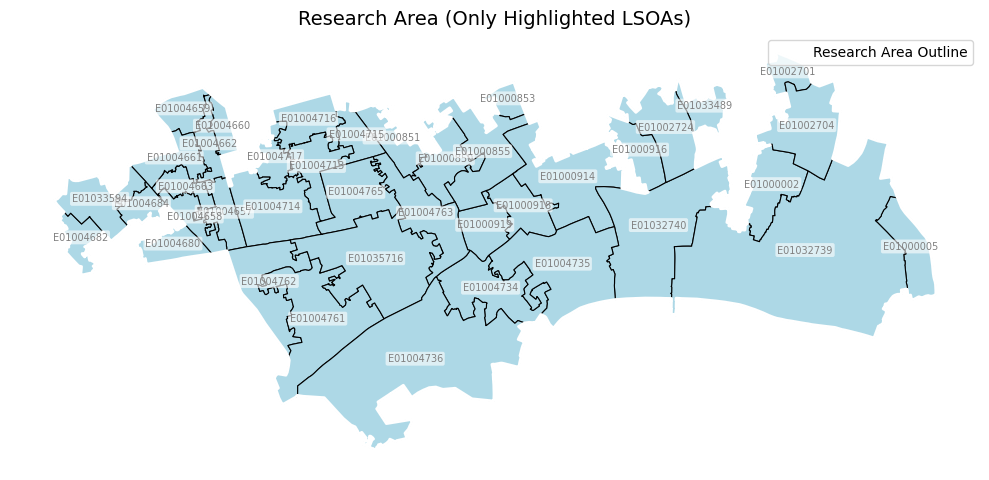

In [ ]:
# Add E01035716 to the list of selected LSOAs (if not already present)
selected_lsoa_codes.append("E01035716")  # Use set() or check for duplicates if needed

# Select polygons for the research area LSOAs
highlighted_lsoa = combined_gdf[combined_gdf["lsoa21cd"].isin(selected_lsoa_codes)]
research_area_outline = unary_union(highlighted_lsoa.geometry)

# Create a figure showing only the research area
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the selected LSOAs with light blue fill and black edges
highlighted_lsoa.plot(ax=ax, color="lightblue", edgecolor="black", linewidth=0.8)

# Add LSOA code labels at the centroid of each polygon
for idx, row in highlighted_lsoa.iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y, row["lsoa21cd"],
        fontsize=7, ha='center', color='grey',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, boxstyle='round,pad=0.2')
    )

# Draw the outline of the research area (in black)
gpd.GeoSeries([research_area_outline], crs="EPSG:4326").boundary.plot(
    ax=ax, edgecolor="white", linewidth=2, label="Research Area Outline"
)

# Final formatting
plt.title("Research Area (Only Highlighted LSOAs)", fontsize=14)
plt.axis("off")
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
highlighted_lsoa.to_file("/content/drive/MyDrive/GEOG0105/research_area.shp", encoding="utf-8")
